# Predict the Credit_Mix category for a customer based on their financial data, and provide actionable insights to improve credit health.

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, roc_auc_score, roc_curve)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

In [39]:
print("Loading dataset...")
url = 'https://raw.githubusercontent.com/rashakil-ds/Public-Datasets/refs/heads/main/Bank%20Data.csv'
df = pd.read_csv(url)

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

Loading dataset...
Dataset shape: (50000, 27)
Columns: ['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age', 'Payment_of_Min_Amount', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance']


In [18]:
df.columns

Index(['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation',
       'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance'],
      dtype='object')

# Project Workflow

In order to do this project, must follow this structure....

## 1. Data Preprocessing
- Handle missing and invalid values in the dataset.
- Encode categorical variables appropriately.
- Scale and normalize numeric features for uniformity.
- Detect and address outliers to improve model stability.

In [40]:
print("\n" + "="*60)
print("STEP 1: COMPREHENSIVE DATA CLEANING")
print("="*60)

def clean_numerical_value(value):
    """Clean numerical values that might contain strings or special characters"""
    if pd.isna(value):
        return np.nan
    if isinstance(value, str):
        # Remove underscores, commas, and other non-numeric characters
        cleaned = ''.join(char for char in value if char.isdigit() or char == '.' or char == '-')
        if cleaned and cleaned != '-':
            try:
                return float(cleaned)
            except ValueError:
                return np.nan
        else:
            return np.nan
    return float(value)

def parse_credit_history_age(age_str):
    """Convert Credit_History_Age from string to numerical years"""
    if pd.isna(age_str):
        return np.nan
    try:
        age_str = str(age_str)
        if 'Years' in age_str and 'Months' in age_str:
            years_part = age_str.split('Years')[0].strip()
            years = int(''.join(filter(str.isdigit, years_part)))

            months_part = age_str.split('and')[1] if 'and' in age_str else age_str.split('Years')[1]
            months = int(''.join(filter(str.isdigit, months_part)))
            return years + months/12

        elif 'Years' in age_str:
            years_part = age_str.split('Years')[0].strip()
            years = int(''.join(filter(str.isdigit, years_part)))
            return years

        else:
            return np.nan
    except:
        return np.nan

# Create a clean copy
df_clean = df.copy()

# Drop irrelevant columns
columns_to_drop = ['ID', 'Customer_ID', 'Name', 'SSN', 'Month']
df_clean = df_clean.drop(columns_to_drop, axis=1, errors='ignore')
print(f"Dropped columns: {columns_to_drop}")

# Define numerical columns that need cleaning
numerical_cols_to_clean = [
    'Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
    'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
    'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
    'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Total_EMI_per_month',
    'Amount_invested_monthly', 'Monthly_Balance'
]

# Clean numerical columns
print("Cleaning numerical columns...")
for col in numerical_cols_to_clean:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].apply(clean_numerical_value)

# Clean specific columns
df_clean['Occupation'] = df_clean['Occupation'].replace(['_______', ''], 'Unknown')
df_clean['Type_of_Loan'] = df_clean['Type_of_Loan'].fillna('Not Specified')

# Convert Credit_History_Age
print("Converting Credit_History_Age...")
df_clean['Credit_History_Age_Years'] = df_clean['Credit_History_Age'].apply(parse_credit_history_age)
df_clean = df_clean.drop('Credit_History_Age', axis=1)

# Handle missing values
print("Handling missing values...")
numerical_cols = df_clean.select_dtypes(include=[np.number]).columns
categorical_cols = df_clean.select_dtypes(include=['object']).columns

for col in numerical_cols:
    if df_clean[col].isnull().sum() > 0:
        df_clean[col].fillna(df_clean[col].median(), inplace=True)

for col in categorical_cols:
    if df_clean[col].isnull().sum() > 0:
        df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)

# First, let's check the unique values in Credit_Mix before encoding
print("Unique values in Credit_Mix:", df_clean['Credit_Mix'].unique())

# Handle any unexpected values in Credit_Mix
credit_mix_mapping = {
    'Poor': 'Poor',
    'Standard': 'Standard',
    'Good': 'Good',
    '_Poor': 'Poor',  # Handle potential typos
    '_Standard': 'Standard',
    '_Good': 'Good'
}

df_clean['Credit_Mix'] = df_clean['Credit_Mix'].map(credit_mix_mapping).fillna('Standard')  # Default to Standard for unknown values

print("Unique values in Credit_Mix after cleaning:", df_clean['Credit_Mix'].unique())





STEP 1: COMPREHENSIVE DATA CLEANING
Dropped columns: ['ID', 'Customer_ID', 'Name', 'SSN', 'Month']
Cleaning numerical columns...
Converting Credit_History_Age...
Handling missing values...
Unique values in Credit_Mix: ['Good' '_' 'Standard' 'Bad']
Unique values in Credit_Mix after cleaning: ['Good' 'Standard']


In [41]:
# Encode categorical variables
print("Encoding categorical variables...")
cols_to_encode = ['Occupation', 'Payment_of_Min_Amount', 'Payment_Behaviour']
df_encoded = pd.get_dummies(df_clean, columns=cols_to_encode, drop_first=True)

# Label encode Credit_Mix and Type_of_Loan
label_encoders = {}
for col in ['Credit_Mix', 'Type_of_Loan']:
    if col in df_encoded.columns:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
        label_encoders[col] = le
        if col == 'Credit_Mix':
            print(f"Credit_Mix encoding: {dict(zip(le.classes_, le.transform(le.classes_)))}")

Encoding categorical variables...
Credit_Mix encoding: {'Good': np.int64(0), 'Standard': np.int64(1)}


In [42]:
# Handle outliers using IQR method
print("Handling outliers...")
numerical_cols = df_encoded.select_dtypes(include=[np.number]).columns.tolist()
if 'Credit_Mix' in numerical_cols:
    numerical_cols.remove('Credit_Mix')

for col in numerical_cols:
    Q1 = df_encoded[col].quantile(0.25)
    Q3 = df_encoded[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_encoded[col] = np.where(df_encoded[col] < lower_bound, lower_bound, df_encoded[col])
    df_encoded[col] = np.where(df_encoded[col] > upper_bound, upper_bound, df_encoded[col])

print("Data cleaning completed!")
print(f"Final dataset shape: {df_encoded.shape}")
print(f"Missing values: {df_encoded.isnull().sum().sum()}")
print(f"Credit_Mix value counts: {df_encoded['Credit_Mix'].value_counts().to_dict()}")

Handling outliers...
Data cleaning completed!
Final dataset shape: (50000, 42)
Missing values: 0
Credit_Mix value counts: {1: 37740, 0: 12260}


## 2. Exploratory Data Analysis (EDA)
- Perform descriptive statistics to understand the data distribution.
- Visualize relationships between features and the target variable.
- Analyze correlations and identify trends or anomalies in the data.


STEP 2: EXPLORATORY DATA ANALYSIS
Number of unique Credit_Mix values: 2


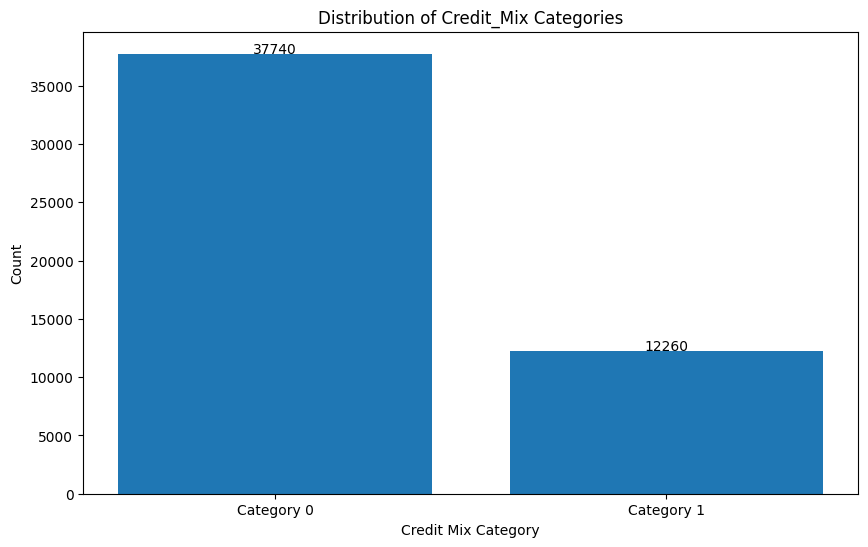

Credit_Mix encoding mapping: {np.int64(0): 'Good', np.int64(1): 'Standard'}


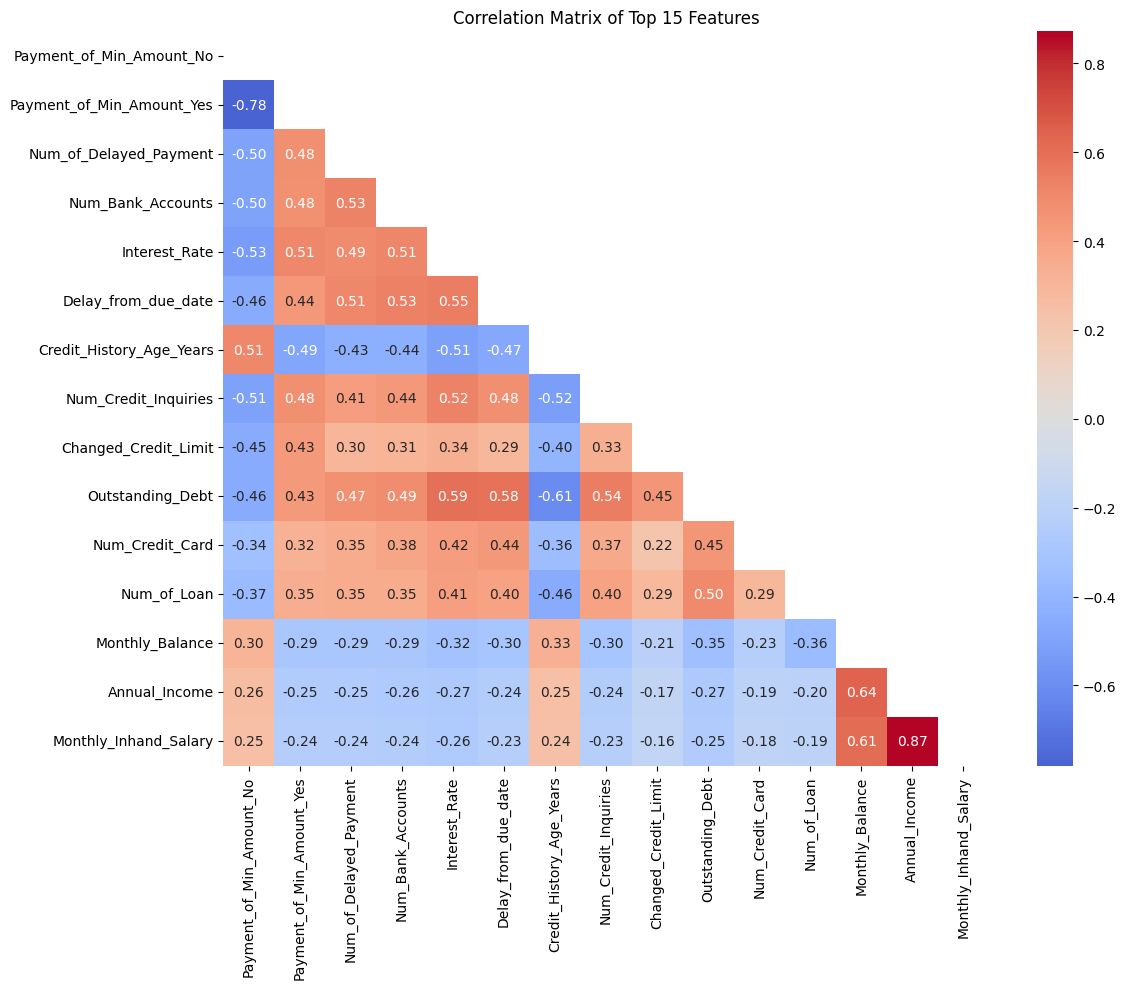

In [47]:
print("\n" + "="*60)
print("STEP 2: EXPLORATORY DATA ANALYSIS")
print("="*60)

# Check the actual number of unique values in Credit_Mix
unique_credit_mix = df_encoded['Credit_Mix'].nunique()
print(f"Number of unique Credit_Mix values: {unique_credit_mix}")

# Target distribution - dynamically handle the number of categories
target_counts = df_encoded['Credit_Mix'].value_counts()
credit_mix_labels = [f'Category {i}' for i in range(unique_credit_mix)]

plt.figure(figsize=(10, 6))
plt.bar(credit_mix_labels, target_counts.values)
plt.title('Distribution of Credit_Mix Categories')
plt.xlabel('Credit Mix Category')
plt.ylabel('Count')
for i, v in enumerate(target_counts.values):
    plt.text(i, v + 10, str(v), ha='center')
plt.show()

# Get the actual mapping from the label encoder
if 'Credit_Mix' in label_encoders:
    credit_mix_mapping = dict(zip(label_encoders['Credit_Mix'].transform(label_encoders['Credit_Mix'].classes_),
                                 label_encoders['Credit_Mix'].classes_))
    print("Credit_Mix encoding mapping:", credit_mix_mapping)

# Correlation matrix (top 15 features)
plt.figure(figsize=(12, 10))
correlation_with_target = df_encoded.corr()['Credit_Mix'].abs().sort_values(ascending=False)
top_features = correlation_with_target.index[1:16]  # Exclude target itself

corr_matrix = df_encoded[top_features].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', center=0, annot=True, fmt='.2f')
plt.title('Correlation Matrix of Top 15 Features')
plt.tight_layout()
plt.show()

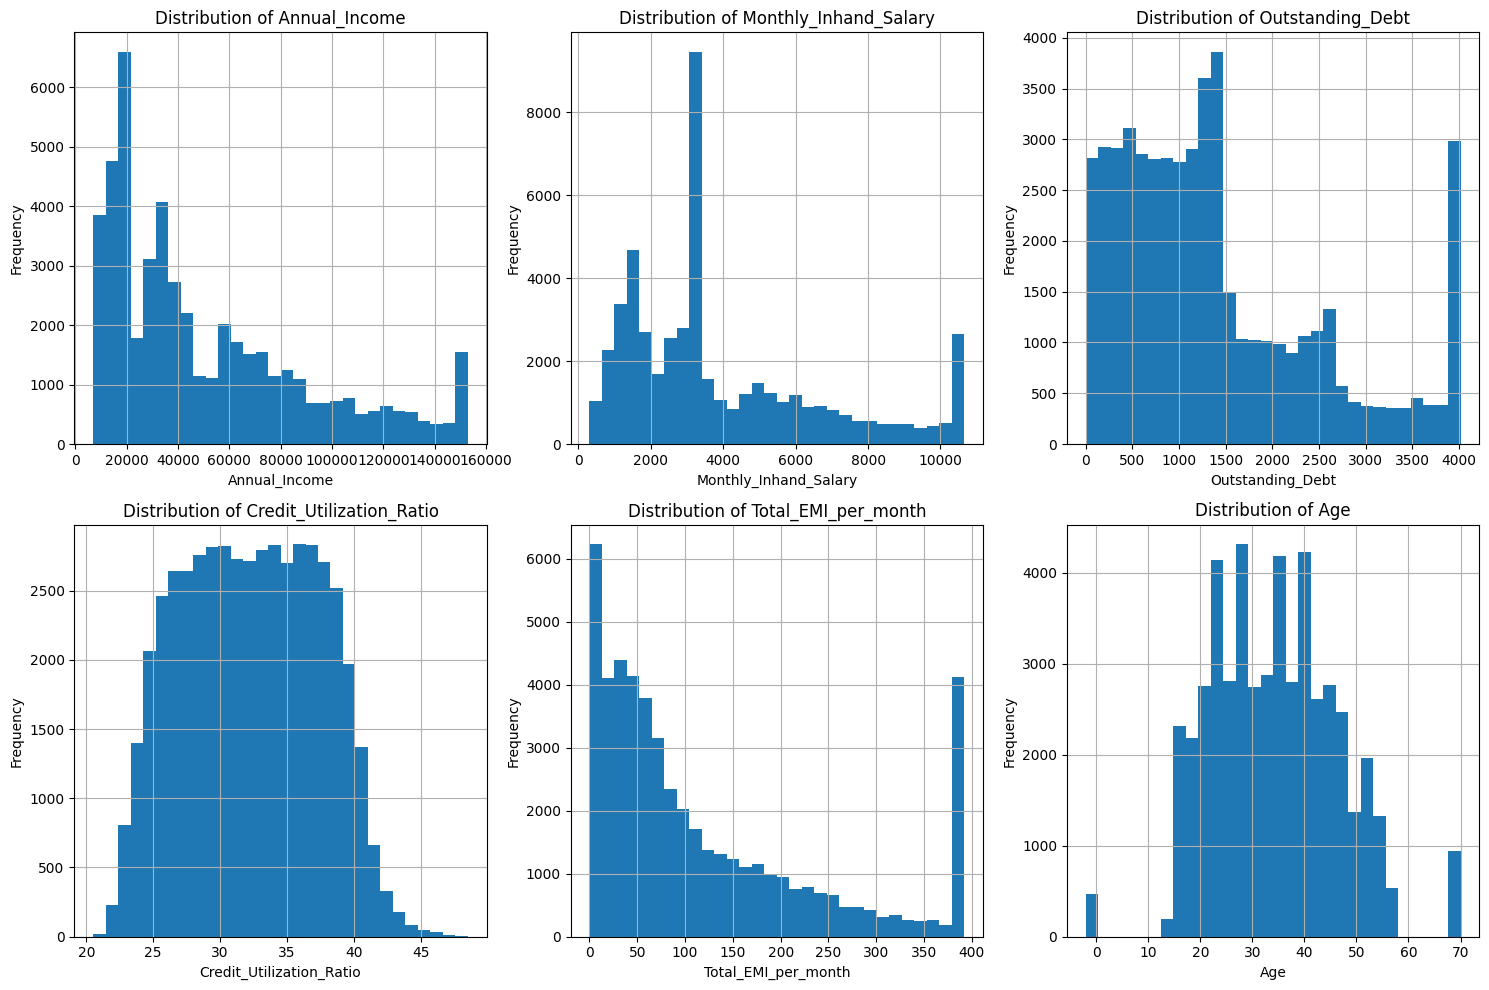

In [46]:
# Distribution of key features
key_features = ['Annual_Income', 'Monthly_Inhand_Salary', 'Outstanding_Debt',
                'Credit_Utilization_Ratio', 'Total_EMI_per_month', 'Age']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, feature in enumerate(key_features):
    if feature in df_encoded.columns:
        df_encoded[feature].hist(bins=30, ax=axes[i])
        axes[i].set_title(f'Distribution of {feature}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## 3. Model Building
- Train multiple machine learning models using the preprocessed data.
- Evaluate the suitability of various models for the task.


In [48]:
print("\n" + "="*60)
print("STEP 3: MODEL BUILDING")
print("="*60)

# Prepare features and target
X = df_encoded.drop('Credit_Mix', axis=1)
y = df_encoded['Credit_Mix']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")
print(f"Target distribution in training: {pd.Series(y_train).value_counts().to_dict()}")
print(f"Target distribution in testing: {pd.Series(y_test).value_counts().to_dict()}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier(n_jobs=-1),
    'Naive Bayes': GaussianNB(),
    'AdaBoost': AdaBoostClassifier(random_state=42)
}

initial_results = {}
print("Training models...")

for name, model in models.items():
    print(f"  - {name}")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    initial_results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }



STEP 3: MODEL BUILDING
Training set: (40000, 41), Testing set: (10000, 41)
Target distribution in training: {1: 30192, 0: 9808}
Target distribution in testing: {1: 7548, 0: 2452}
Training models...
  - Logistic Regression
  - Random Forest
  - Gradient Boosting
  - SVM
  - K-Nearest Neighbors
  - Naive Bayes
  - AdaBoost


In [49]:
# Create results dataframe
results_df = pd.DataFrame.from_dict(initial_results, orient='index')
results_df = results_df[['accuracy', 'precision', 'recall', 'f1']]
results_df = results_df.sort_values('f1', ascending=False)

print("\nInitial Model Performance:")
print(results_df.round(4))


Initial Model Performance:
                     accuracy  precision  recall      f1
Random Forest          0.9236     0.9302  0.9236  0.9254
Gradient Boosting      0.9132     0.9202  0.9132  0.9152
SVM                    0.9049     0.9128  0.9049  0.9072
Logistic Regression    0.9004     0.9039  0.9004  0.9017
AdaBoost               0.8995     0.9028  0.8995  0.9008
K-Nearest Neighbors    0.8649     0.8711  0.8649  0.8672
Naive Bayes            0.8157     0.8933  0.8157  0.8280


## 4. Model Evaluation
- Compute and plot evaluation metrics for all models, such as accuracy, precision, recall, F1-score, and AUC-ROC.
- Compare the performance of models across multiple metrics.



STEP 4: MODEL EVALUATION


<Figure size 1200x800 with 0 Axes>

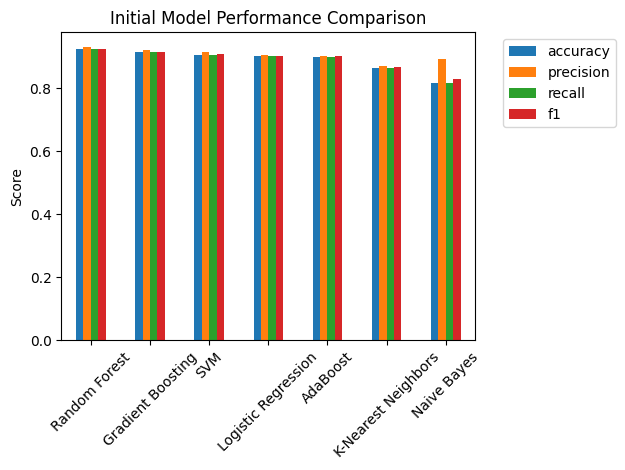

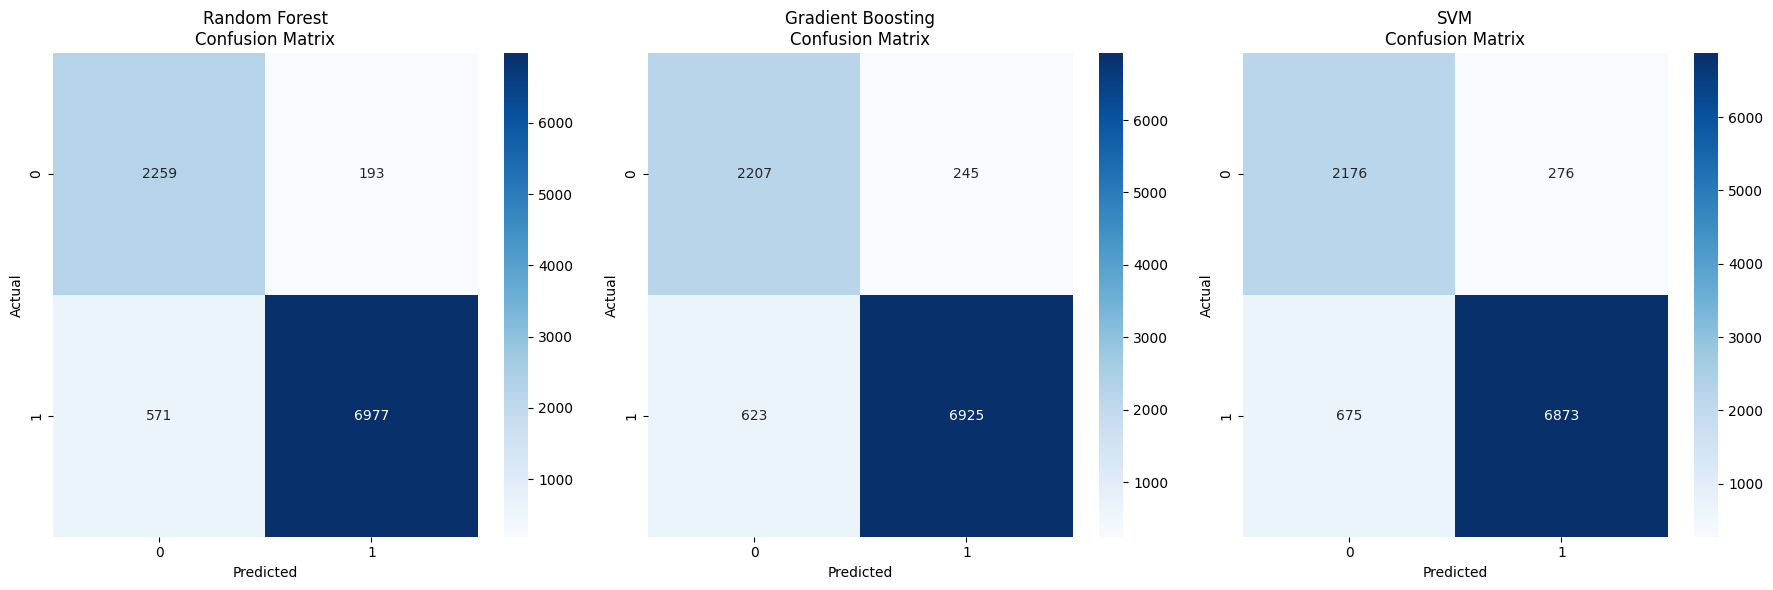

In [50]:
print("\n" + "="*60)
print("STEP 4: MODEL EVALUATION")
print("="*60)

# Plot performance comparison
plt.figure(figsize=(12, 8))
results_df.plot(kind='bar')
plt.title('Initial Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Confusion matrices for top 3 models
top_models = results_df.head(3).index
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, model_name in enumerate(top_models):
    model = initial_results[model_name]['model']
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'{model_name}\nConfusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [51]:
# Detailed report for best model
best_model_name = results_df.index[0]
best_model = initial_results[best_model_name]['model']
y_pred_best = best_model.predict(X_test_scaled)

print(f"\nClassification Report for {best_model_name}:")
print(classification_report(y_test, y_pred_best))


Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.80      0.92      0.86      2452
           1       0.97      0.92      0.95      7548

    accuracy                           0.92     10000
   macro avg       0.89      0.92      0.90     10000
weighted avg       0.93      0.92      0.93     10000



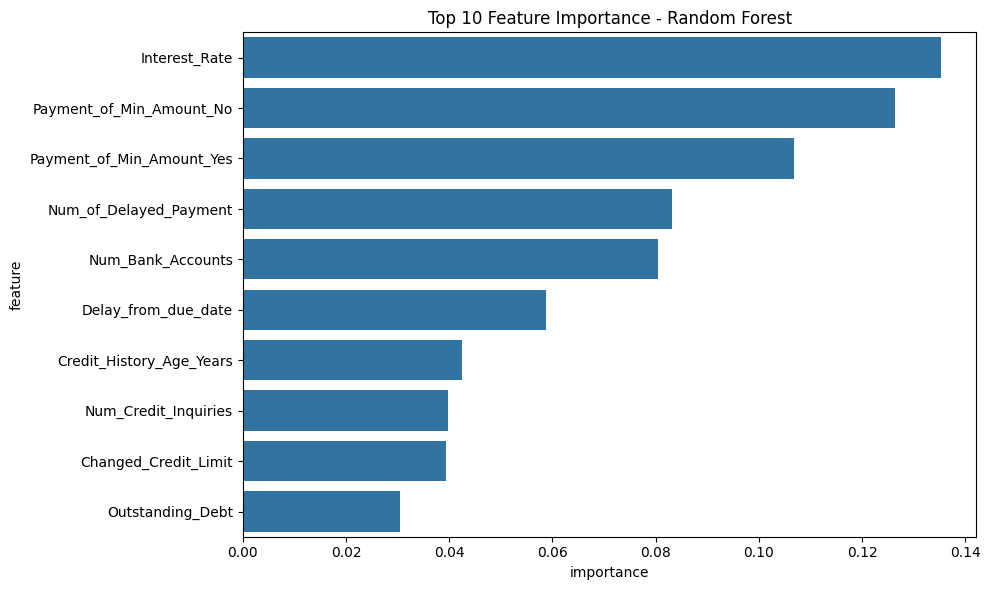

In [52]:
# Feature importance for tree-based models
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    })
    feature_importance = feature_importance.sort_values('importance', ascending=False).head(10)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title(f'Top 10 Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.show()

## 5. Hyperparameter Tuning
- Optimize hyperparameters for each model using systematic search methods.
- Identify the best configuration for improved performance.


In [53]:
print("\n" + "="*60)
print("STEP 5: HYPERPARAMETER TUNING")
print("="*60)

# Tune top 2 models for efficiency
param_grids = {
    'Random Forest': {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [3, 5],
        'subsample': [0.8, 1.0]
    }
}

tuned_models = {}
models_to_tune = ['Random Forest', 'Gradient Boosting']

for model_name in models_to_tune:
    if model_name in initial_results:
        print(f"Tuning {model_name}...")

        random_search = RandomizedSearchCV(
            initial_results[model_name]['model'],
            param_grids[model_name],
            n_iter=10,  # Reduced for speed
            cv=3,
            scoring='f1_weighted',
            random_state=42,
            n_jobs=-1
        )

        random_search.fit(X_train_scaled, y_train)

        tuned_models[model_name] = {
            'model': random_search.best_estimator_,
            'params': random_search.best_params_,
            'score': random_search.best_score_
        }

        print(f"Best parameters: {random_search.best_params_}")
        print(f"Best CV score: {random_search.best_score_:.4f}")


STEP 5: HYPERPARAMETER TUNING
Tuning Random Forest...
Best parameters: {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20}
Best CV score: 0.9218
Tuning Gradient Boosting...
Best parameters: {'subsample': 1.0, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}
Best CV score: 0.9124


In [54]:
# Evaluate tuned models
print("\nEvaluating tuned models:")
for model_name in tuned_models:
    model = tuned_models[model_name]['model']
    y_pred = model.predict(X_test_scaled)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"{model_name} - Accuracy: {accuracy:.4f}, F1: {f1:.4f}")

    # Compare with original model
    original_f1 = initial_results[model_name]['f1']
    improvement = ((f1 - original_f1) / original_f1) * 100
    print(f"F1 Score Improvement: {improvement:.2f}%")


Evaluating tuned models:
Random Forest - Accuracy: 0.9234, F1: 0.9253
F1 Score Improvement: -0.01%
Gradient Boosting - Accuracy: 0.9142, F1: 0.9163
F1 Score Improvement: 0.12%


## 6. Retrain Models
- Retrain all models using the optimal hyperparameters on the training data.
- Validate the models on unseen data to ensure robustness.

In [55]:
final_models = {}

if tuned_models:
    print("Retraining tuned models with optimal parameters...")
    for model_name, tuning_info in tuned_models.items():
        best_params = tuning_info['params']

        if model_name == 'Random Forest':
            final_model = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
        elif model_name == 'Gradient Boosting':
            final_model = GradientBoostingClassifier(**best_params, random_state=42)
        elif model_name == 'Logistic Regression':
            final_model = LogisticRegression(**best_params, random_state=42, max_iter=1000)
        else:
            # Use the original model if not one of the expected types
            final_model = initial_results[model_name]['model']

        # Retrain on full training data
        final_model.fit(X_train_scaled, y_train)
        final_models[model_name] = final_model
        print(f"Retrained {model_name} with optimal parameters")
else:
    # If no tuning was done, use the best initial model
    best_model_name = results_df.index[0]
    final_model = initial_results[best_model_name]['model']
    final_models[best_model_name] = final_model
    print(f"Using best initial model: {best_model_name}")

Retraining tuned models with optimal parameters...
Retrained Random Forest with optimal parameters
Retrained Gradient Boosting with optimal parameters


In [56]:
# Also retrain the best model from initial results for comparison
if not tuned_models:
    best_model_name = results_df.index[0]
    final_model = initial_results[best_model_name]['model']
    final_models[best_model_name] = final_model

print("Models retrained successfully!")

Models retrained successfully!


## 7. Final Performance and Cross-Validation
- Evaluate the final performance of each model using cross-validation scores.
- Compare results to select the best-performing model.


In [57]:
final_results = {}

for model_name, model in final_models.items():
    print(f"Evaluating {model_name}...")

    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled) if hasattr(model, 'predict_proba') else None

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='f1_weighted')

    final_results[model_name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }

    print(f"  Test F1: {f1:.4f}, CV Mean F1: {cv_scores.mean():.4f} (±{cv_scores.std()*2:.4f})")



Evaluating Random Forest...
  Test F1: 0.9253, CV Mean F1: 0.9230 (±0.0049)
Evaluating Gradient Boosting...
  Test F1: 0.9163, CV Mean F1: 0.9132 (±0.0043)


In [58]:
# Create final results dataframe
final_results_df = pd.DataFrame.from_dict(final_results, orient='index')
final_results_df = final_results_df[['accuracy', 'precision', 'recall', 'f1', 'cv_mean', 'cv_std']]
final_results_df = final_results_df.sort_values('f1', ascending=False)

print("\nFinal Model Performance Comparison:")
print(final_results_df.round(4))

# Select the best final model
best_final_model_name = final_results_df.index[0]
best_final_model = final_results[best_final_model_name]['model']
print(f"\nBest performing model: {best_final_model_name}")

# Detailed evaluation of the best model
y_pred_final = best_final_model.predict(X_test_scaled)
y_pred_proba_final = best_final_model.predict_proba(X_test_scaled) if hasattr(best_final_model, 'predict_proba') else None

print(f"\nDetailed Classification Report for {best_final_model_name}:")
print(classification_report(y_test, y_pred_final))


Final Model Performance Comparison:
                   accuracy  precision  recall      f1  cv_mean  cv_std
Random Forest        0.9234     0.9307  0.9234  0.9253   0.9230  0.0024
Gradient Boosting    0.9142     0.9219  0.9142  0.9163   0.9132  0.0021

Best performing model: Random Forest

Detailed Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.79      0.93      0.86      2452
           1       0.97      0.92      0.95      7548

    accuracy                           0.92     10000
   macro avg       0.88      0.92      0.90     10000
weighted avg       0.93      0.92      0.93     10000



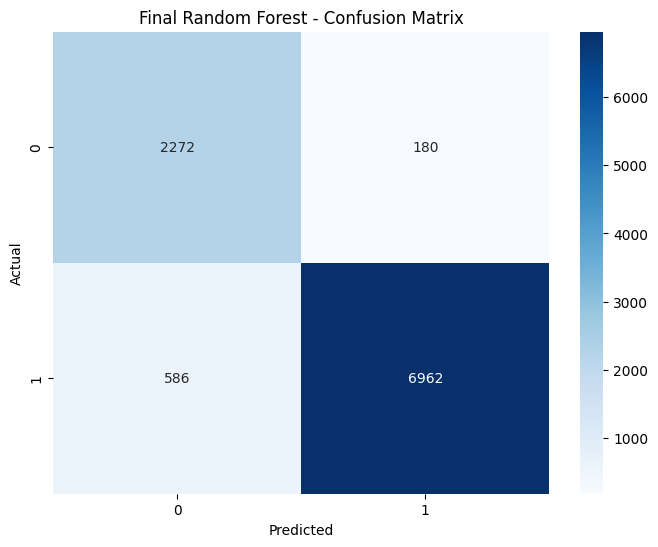

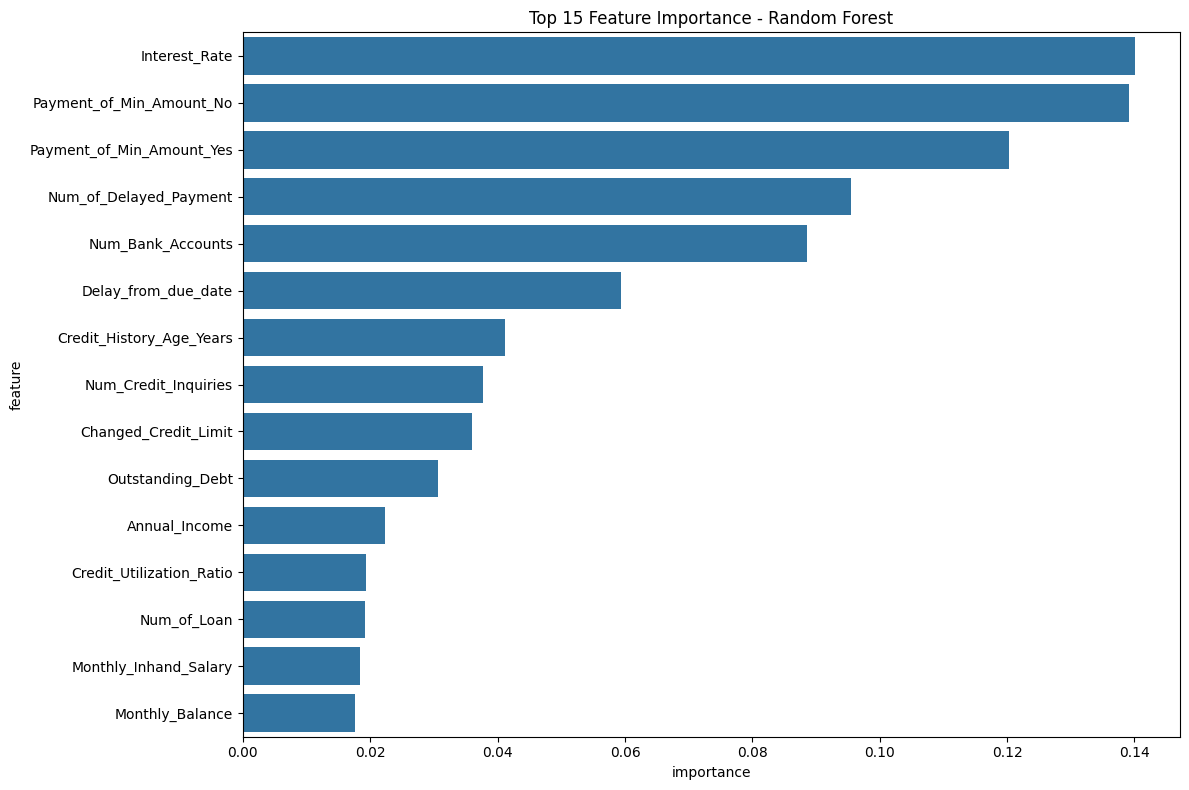

Top 10 Most Important Features:
  Interest_Rate: 0.1401
  Payment_of_Min_Amount_No: 0.1391
  Payment_of_Min_Amount_Yes: 0.1203
  Num_of_Delayed_Payment: 0.0955
  Num_Bank_Accounts: 0.0885
  Delay_from_due_date: 0.0594
  Credit_History_Age_Years: 0.0411
  Num_Credit_Inquiries: 0.0377
  Changed_Credit_Limit: 0.0360
  Outstanding_Debt: 0.0306


In [59]:
# Confusion matrix for the best model
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Final {best_final_model_name} - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature importance for tree-based models
if hasattr(best_final_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_final_model.feature_importances_
    })
    feature_importance = feature_importance.sort_values('importance', ascending=False).head(15)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title(f'Top 15 Feature Importance - {best_final_model_name}')
    plt.tight_layout()
    plt.show()

    print("Top 10 Most Important Features:")
    for i, row in feature_importance.head(10).iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")

## 8. Suggestions
- Provide recommendations based on the model insights and analysis.
- Suggest actionable steps to improve outcomes or address any gaps identified during the project.


In [60]:
# Get feature importance for recommendations
if hasattr(best_final_model, 'feature_importances_'):
    top_features = feature_importance.head(5)['feature'].tolist()
else:
    # Fallback: use correlation if feature importance is not available
    top_features = df_encoded.corr()['Credit_Mix'].abs().sort_values(ascending=False).index[1:6].tolist()

print("TOP PREDICTORS OF CREDIT HEALTH:")
for i, feature in enumerate(top_features, 1):
    print(f"{i}. {feature}")

print("""
ACTIONABLE RECOMMENDATIONS:

1. FOR CUSTOMERS:
   - MONITOR CREDIT UTILIZATION: Keep credit utilization below 30% of available credit
   - MAINTAIN PAYMENT CONSISTENCY: Ensure timely payments to build positive credit history
   - MANAGE DEBT-TO-INCOME RATIO: Keep total debt payments below 36% of monthly income
   - DIVERSIFY CREDIT TYPES: Maintain a healthy mix of credit types (cards, loans, mortgages)
   - REGULAR CREDIT REPORT CHECKS: Monitor credit reports quarterly for errors or fraud

2. FOR FINANCIAL INSTITUTIONS:
   - IMPLEMENT EARLY WARNING SYSTEM: Use this model to identify at-risk customers 3-6 months in advance
   - PERSONALIZED CREDIT BUILDING PLANS: Develop customized strategies based on individual customer profiles
   - TARGETED PRODUCT OFFERINGS: Offer credit-building products to customers with improving scores
   - PROACTIVE CUSTOMER OUTREACH: Contact customers showing signs of credit deterioration
   - FINANCIAL EDUCATION PROGRAMS: Provide resources on credit management and financial literacy

3. CREDIT IMPROVEMENT STRATEGIES BY CATEGORY:""")



TOP PREDICTORS OF CREDIT HEALTH:
1. Interest_Rate
2. Payment_of_Min_Amount_No
3. Payment_of_Min_Amount_Yes
4. Num_of_Delayed_Payment
5. Num_Bank_Accounts

ACTIONABLE RECOMMENDATIONS:

1. FOR CUSTOMERS:
   - MONITOR CREDIT UTILIZATION: Keep credit utilization below 30% of available credit
   - MAINTAIN PAYMENT CONSISTENCY: Ensure timely payments to build positive credit history
   - MANAGE DEBT-TO-INCOME RATIO: Keep total debt payments below 36% of monthly income
   - DIVERSIFY CREDIT TYPES: Maintain a healthy mix of credit types (cards, loans, mortgages)
   - REGULAR CREDIT REPORT CHECKS: Monitor credit reports quarterly for errors or fraud

2. FOR FINANCIAL INSTITUTIONS:
   - IMPLEMENT EARLY WARNING SYSTEM: Use this model to identify at-risk customers 3-6 months in advance
   - PERSONALIZED CREDIT BUILDING PLANS: Develop customized strategies based on individual customer profiles
   - TARGETED PRODUCT OFFERINGS: Offer credit-building products to customers with improving scores
   - PR